# Figure S5B
## Event rasters

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [52]:
# Typing

from typing import (
    Optional,
)
from pandas import (
    DataFrame,
)

# Others

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents

#### Parameters

In [53]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-s5b.yaml'
params = uutils.load_params( params_path )

# Choices for `variant`:
# * 'wt_prop'   - Fig. S5B, left
# * 'wt_static' - Fig. S5B, right
variant = 'wt_prop'

params.update( params['variants'][variant] )

#### Initial setup

In [54]:
helper = Helper(
    config_path = params['helper_configs'],
    hive_root = params['hive_root'],
    output_to = params['output_parent'],
)

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']

save_figure = helper.figure_saver( notebook_stem, variant )
save_data = helper.data_saver( notebook_stem, variant )
save_csv = helper.csv_saver( notebook_stem, variant )

---

## Load data

In [55]:
events_analyze = helper.load_analysis_events(
    params['analysis'],
    extra_decorators = [],
    verbose = True
)

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 23.00it/s] 
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 23.12it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 32.52it/s]



Experiment GABA
    Excluded cells: 154
    Included cells: 164


Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99



In [56]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

In [57]:
comparison_key = params['comparison_key']
comparison_groups = params['comparison']

if params['event_type'].lower().startswith( 'prop' ):
    events_subset = events_prop.copy()
elif params['event_type'].lower().startswith( 'static' ):
    events_subset = events_no_prop.copy()
elif params['event_type'].lower().startswith( 'all' ):
    events_subset = events_analyze.copy()
else:
    raise ValueError( f'Unrecognized event type: {params["event_type"]}' )

filter_events_condition = events_subset[comparison_key].isin( comparison_groups )
filter_events_neighbor = events_subset['is_uncage'] == False
filter_events_panel = filter_events_condition & filter_events_neighbor

events_panel = events_subset.copy()[filter_events_panel]

# TODO In the paper figures, sorting was done by post-uncaging static event rate
filter_events_condition_sort = events_no_prop[comparison_key].isin( comparison_groups )
filter_events_neighbor_sort = events_no_prop['is_uncage'] == False
filter_events_panel_sort = filter_events_condition_sort & filter_events_neighbor_sort
events_sort = events_no_prop.copy()[filter_events_panel_sort]

#### Characterize $n$

In [58]:
uevents.summarize_n( events_panel )

Mice:            n = 7
Slices:          n = 16
Datasets:        n = 87
Cell-recordings: n = 333
Cells:           n = 250
Events:          n = 3043
Slices per mouse:
    Low:  1
    High: 3
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  2
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  1
    High: 52

** GABA:
Datasets:        n = 28
Cell-recordings: n = 135
Events:          n = 1358
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 115
Events:          n = 1112
Cells per dataset:
    Low:  1
    High: 7


#### Result: Event raster

#### TODO
Functionalize these

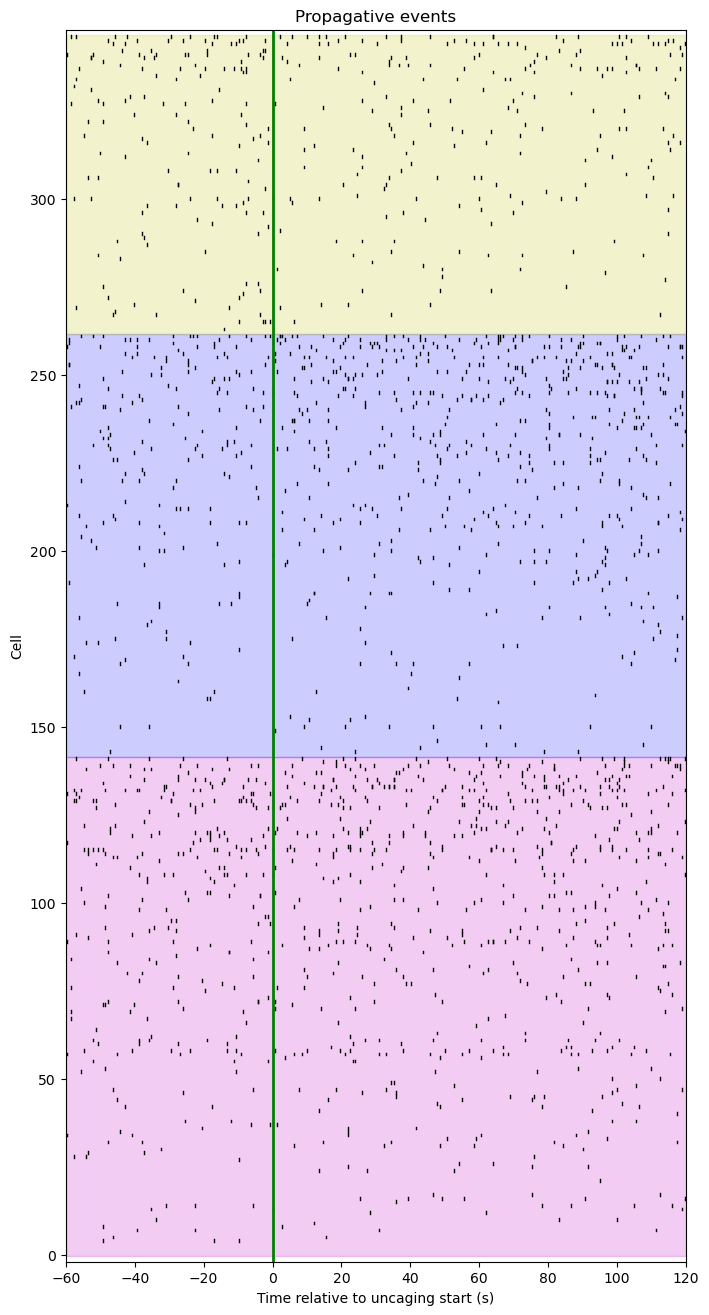

In [59]:
experiments_plot = params['comparison']
experiment_colors = [ helper.condition_colors[e]
                      for e in experiments_plot ]

# window_pre = params['window_pre']
# window_post = params['window_post']

# ratio_threshold = params['ratio_threshold']

group_key = params['group_key']
coreg_key = params['coreg_key']

window_plot = params['window_plot']
window_sort = params['window_sort']

#

plt.figure( figsize = (8, 16) )

cur_row = 0
experiment_start = None
experiment_groups_sorted = dict()

for experiment, color in zip( experiments_plot, experiment_colors ):
    
    filter_events_experiment = events_panel['condition'] == experiment
    events_cur = events_panel[filter_events_experiment]

    filter_events_experiment_sort = events_sort['condition'] == experiment
    events_cur_sort = events_sort[filter_events_experiment_sort]

    #
    
    experiment_start = cur_row - 0.5
    
    # Determine sort order
    group_sum = dict()
    for group, df_group in events_cur_sort.groupby( group_key ):
        filter_window = uevents.is_within(
            df_group['start_time_rel'],
            window_sort
        )
        group_sum[group] = np.sum( filter_window )
    groups_sorted = list( map( lambda x: x[0],
                               sorted( group_sum.items(),
                                       key = lambda y: y[1] ) ) )
    experiment_groups_sorted[experiment] = groups_sorted

    for group in groups_sorted:
    
        filter_group = events_cur[group_key] == group
        df_group = events_cur[filter_group]

        filter_window = uevents.is_within(
            df_group['start_time_rel'],
            window_plot
        )
        df_group_window = df_group[filter_window]
    
        ts = df_group_window['start_time_rel']
        
        for t in ts:
            plt.plot(
                [t, t], [cur_row - 0.4, cur_row + 0.4],
                'k-',
                linewidth = 1
            )
        
        cur_row = cur_row + 1
        
    experiment_end = cur_row - 0.5
    
    plt.fill_between(
        [-60, 120], [experiment_start, experiment_start], [experiment_end, experiment_end],
        color = color,
        alpha = 0.2
    )

yl = [-2, cur_row + 1]
plt.ylim( yl )
plt.plot( [0, 0], yl, 'g-', linewidth = 2 )
    
plt.xlim( -60, 120 )

plt.title( f'{params["event_type_description"]} events' )

plt.ylabel( 'Cell' )
plt.xlabel( 'Time relative to uncaging start (s)' )

save_figure( 'raster', 'svg' )

plt.show()